In [1]:
from pathlib import Path
import re
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

PROJECT_ROOT_DIR = Path("..").resolve()
DATA_DIR = PROJECT_ROOT_DIR.joinpath("data")
DATA_DIR.mkdir(exist_ok=True)
SRC_DIR = PROJECT_ROOT_DIR.joinpath("src")
SRC_DIR.mkdir(exist_ok=True)

sys.path.append(str(SRC_DIR))

# Attention mechanisms

Terms:
* self-attention
* Causal attention module


In language, meaning is represented both in tokens and in how they're organized (ie the words used and their order in a sentance, paragraph, chapter/document/book). Machine learning algorithms can only work with matrices of numbers, so we need some reversable way to encode the text to a numeric format and then decode the numeric representation back to text. Encoding the ordering/organization in a way that keeps the meaning available to the model is the hard part, and that's where self-attention made a big breakthrough.



## Simplified self-attention

Given an input sequence, $x$, consisting of $T$ elements ($x^{(1)}$ to $x^{(T)}$), we want to produce a context vector $z^{(i)}$ for each input element $x^{(i)}$. The importance of each input element $x^{(i)}$ on a given context vector $z^{(j)}$ is determined by the attention-weights $a_{j1}$ to $a_{jT}$.

In [2]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

Calculating the dot product for each input token embeddings and a specific token embedding (ie the query).

In [3]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Calculating the dot product of token embeddings 1 ("Your") and 2 ("journey").

In [4]:
res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
    print(
        f"index: {idx}, inputs[0][index]: {inputs[0][idx]},  query[index]: {query[idx]}, res: {res}"
    )
print(res)
print(torch.dot(inputs[0], query))

index: 0, inputs[0][index]: 0.4300000071525574,  query[index]: 0.550000011920929, res: 0.23650000989437103
index: 1, inputs[0][index]: 0.15000000596046448,  query[index]: 0.8700000047683716, res: 0.367000013589859
index: 2, inputs[0][index]: 0.8899999856948853,  query[index]: 0.6600000262260437, res: 0.9544000625610352
tensor(0.9544)
tensor(0.9544)


In [5]:
print(f"query:    {query}")
print(f"input[0]: {inputs[0]}")

query:    tensor([0.5500, 0.8700, 0.6600])
input[0]: tensor([0.4300, 0.1500, 0.8900])


In [6]:
line_45deg = torch.tensor([0.707, 0.707])
line_315deg = torch.tensor([0.707, -0.707])
print(f"dot product for perpendicular lines: {line_45deg.dot(line_315deg)}")
print(f"dot product for parallel lines:      {line_45deg.dot(line_45deg)}")

dot product for perpendicular lines: 0.0
dot product for parallel lines:      0.9996980428695679


In [7]:
line_45deg = torch.tensor([0.7071067811865476, 0.7071067811865476])
line_315deg = torch.tensor([0.7071067811865476, -0.7071067811865476])
print(f"dot product for perpendicular lines: {line_45deg.dot(line_315deg)}")
print(f"dot product for parallel lines:      {line_45deg.dot(line_45deg)}")

dot product for perpendicular lines: 0.0
dot product for parallel lines:      0.9999999403953552


In [8]:
line_45deg = torch.tensor([1, 1])
line_315deg = torch.tensor([1, -1])
print(f"dot product for perpendicular lines: {line_45deg.dot(line_315deg)}")
print(f"dot product for parallel lines:      {line_45deg.dot(line_45deg)}")

dot product for perpendicular lines: 0
dot product for parallel lines:      2


In [9]:
line_45deg = torch.tensor([1, 1, 1])
line_315deg = torch.tensor([1, -1, 0])
print(f"dot product for perpendicular lines: {line_45deg.dot(line_315deg)}")
print(f"dot product for parallel lines:      {line_45deg.dot(line_45deg)}")

dot product for perpendicular lines: 0
dot product for parallel lines:      3


(-1.0, 1.0)

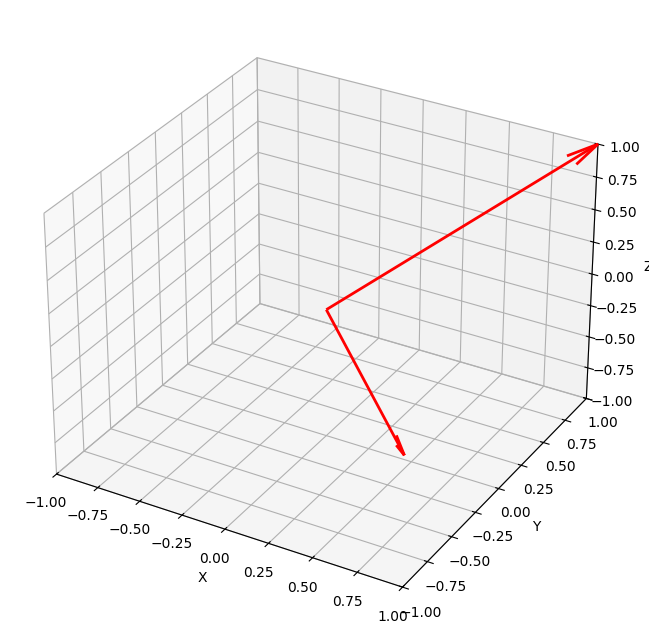

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vector origin (x, y, z)
origin = np.array([0, 0, 0])
vector_a = np.array([1, -1, 0])
vector_b = np.array([1, 1, 1])

# Plot the vector using quiver
# The arguments are: x, y, z (start position), u, v, w (direction components)
ax.quiver(origin[0], origin[1], origin[2],
          vector_a[0], vector_a[1], vector_a[2],
          color='r', arrow_length_ratio=0.1, linewidth=2)
ax.quiver(origin[0], origin[1], origin[2],
          vector_b[0], vector_b[1], vector_b[2],
          color='r', arrow_length_ratio=0.1, linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the axes to properly show the vector
max_range = np.array([*vector_a, *vector_b]).max()
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

Back to calculating attention weights

In [11]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [12]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [13]:
torch.exp(line_45deg)

tensor([2.7183, 2.7183, 2.7183])

In [14]:
torch.exp(line_45deg).sum(dim=0)

tensor(8.1548)

In practice, it's better to use PyTorch's softmax implementation.

In [15]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Back to calculating the context-vector for token-embedding #2 (our `query`).

In [16]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


Calculating attention scores for all input tokens

In [17]:
%%timeit
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

121 μs ± 1.39 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


General process:
1. Calculate attention scores (dot products between inputs)
2. Calculate attention weights (normalize attention scores)
3. Calculate context vectors (sum the weighted inputs)

The nested for loops above demonstrate the idea, but optimized matrix multiplication is much faster.

In [19]:
%%timeit
attn_scores = inputs @ inputs.T

1.63 μs ± 2.37 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [20]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [21]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [22]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [23]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [24]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


## 3.4: Implementing self-attention with trainable weights